In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from analysis.convert import convert_file, root_to_numpy
from analysis.import_data import import_true_reco, reco_and_target
from analysis.mem_ana import constants
from typing import Optional
from math import ceil

sig_cross_sec = constants[f"sigma_zhh"]
bkg_cross_sec = constants[f"sigma_zzh"]

sig_to_bkg = sig_cross_sec/bkg_cross_sec # ca. 0.1

In [2]:
ds = import_true_reco(equal_size=True)
len(ds)

29406

In [6]:
list(ds.columns)

['run',
 'event',
 'error_code',
 'is_zhh',
 'is_zzh',
 'passed_preselection',
 'true_h1_decay_pdg',
 'true_h2_decay_pdg',
 'true_z2_decay_pdg',
 'misclustering_region',
 'misclustering_region_icns',
 'efrac1_reco',
 'efrac2_reco',
 'efrac1_true',
 'efrac2_true',
 'efrac1_icn_reco',
 'efrac2_icn_reco',
 'efrac1_icn_true',
 'efrac2_icn_true',
 'parton1_pdg',
 'parton2_pdg',
 'parton3_pdg',
 'parton4_pdg',
 'parton1_e',
 'parton2_e',
 'parton3_e',
 'parton4_e',
 'true_lep1_e',
 'true_lep2_e',
 'jet1_e',
 'jet2_e',
 'jet3_e',
 'jet4_e',
 'lep1_e',
 'lep2_e',
 'parton1_px',
 'parton1_py',
 'parton1_pz',
 'parton2_px',
 'parton2_py',
 'parton2_pz',
 'parton3_px',
 'parton3_py',
 'parton3_pz',
 'parton4_px',
 'parton4_py',
 'parton4_pz',
 'true_lep1_px',
 'true_lep1_py',
 'true_lep1_pz',
 'true_lep2_px',
 'true_lep2_py',
 'true_lep2_pz',
 'jet1_px',
 'jet1_py',
 'jet1_pz',
 'jet2_px',
 'jet2_py',
 'jet2_pz',
 'jet3_px',
 'jet3_py',
 'jet3_pz',
 'jet4_px',
 'jet4_py',
 'jet4_pz',
 'lep1_px',


In [5]:
import torch
import pyro
import pyro.distributions as dist
import pyro.distributions.transforms as T
import matplotlib.pyplot as plt
import seaborn as sns
import os
smoke_test = ('CI' in os.environ)

In [6]:
dist_x = dist.Normal(torch.zeros(1), torch.ones(1))
affine_transform = T.AffineTransform(loc=3, scale=0.5)
exp_transform = T.ExpTransform()
dist_y = dist.TransformedDistribution(dist_x, [affine_transform, exp_transform])

In [7]:
base_dist = dist.Normal(torch.zeros(2), torch.ones(2))
spline_transform = T.spline_coupling(2, count_bins=16)
flow_dist = dist.TransformedDistribution(base_dist, [spline_transform])

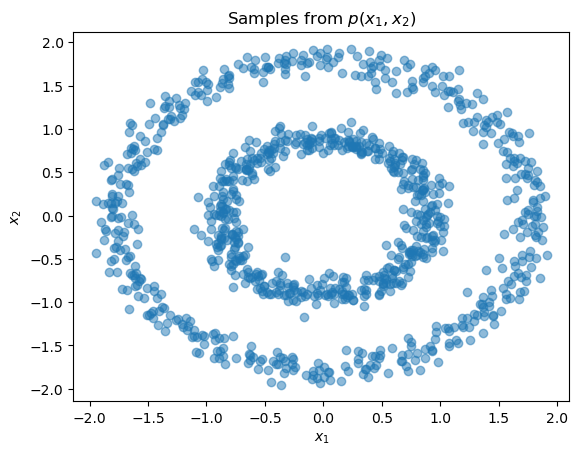

/tmp/ipykernel_51291/718671630.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X[:,0], hist=False, kde=True,
/tmp/ipykernel_51291/718671630.py:23: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X[:,1], hist=False, kde=True,


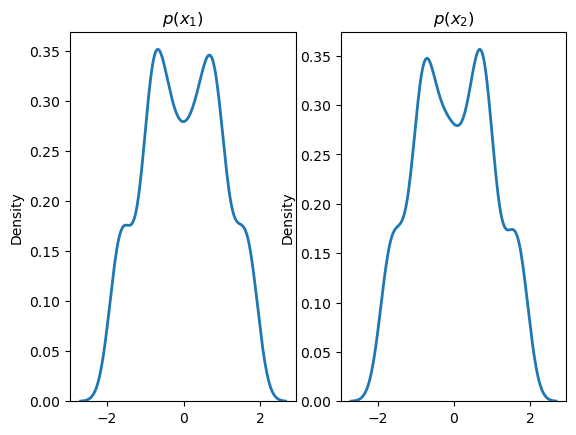

In [10]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

n_samples = 1000
X, y = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
X = StandardScaler().fit_transform(X)

plt.title(r'Samples from $p(x_1,x_2)$')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(X[:,0], X[:,1], alpha=0.5)
plt.show()

plt.subplot(1, 2, 1)
sns.distplot(X[:,0], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.title(r'$p(x_1)$')
plt.subplot(1, 2, 2)
sns.distplot(X[:,1], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.title(r'$p(x_2)$')
plt.show()

In [13]:
steps = 1 if smoke_test else 50001
dataset = torch.tensor(X, dtype=torch.float)
optimizer = torch.optim.Adam(spline_transform.parameters(), lr=3e-3)
for step in range(steps+1):
    optimizer.zero_grad()
    loss = -flow_dist.log_prob(dataset).mean()
    loss.backward()
    optimizer.step()
    flow_dist.clear_cache()

    if step % 500 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

step: 0, loss: 1.861965298652649
step: 500, loss: 1.6604152917861938
step: 1000, loss: 1.6895222663879395
step: 1500, loss: 1.6506357192993164
step: 2000, loss: 1.6549370288848877
step: 2500, loss: 1.6687443256378174
step: 3000, loss: 1.6641137599945068
step: 3500, loss: 1.8871909379959106
step: 4000, loss: 1.673345685005188
step: 4500, loss: 1.6619058847427368
step: 5000, loss: 1.6497797966003418
step: 5500, loss: 1.655860424041748
step: 6000, loss: 1.6643890142440796
step: 6500, loss: 1.6302844285964966
step: 7000, loss: 1.725858211517334
step: 7500, loss: 1.7633415460586548
step: 8000, loss: 1.7599647045135498
step: 8500, loss: 1.6888000965118408
step: 9000, loss: 2.0032052993774414
step: 9500, loss: 1.7735273838043213
step: 10000, loss: 1.6873300075531006
step: 10500, loss: 1.7175346612930298
step: 11000, loss: 1.711245059967041
step: 11500, loss: 1.6546034812927246
step: 12000, loss: 1.6660364866256714
step: 12500, loss: 1.6510190963745117
step: 13000, loss: 1.6634267568588257
ste

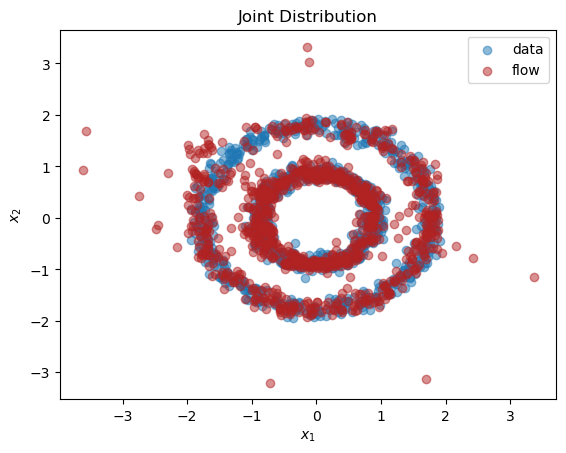

/tmp/ipykernel_51291/3152742130.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X[:,0], hist=False, kde=True,
/tmp/ipykernel_51291/3152742130.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X_flow[:,0], hist=False, kde=True,
/tmp/ipykernel_51291/3152742130.py:23: User

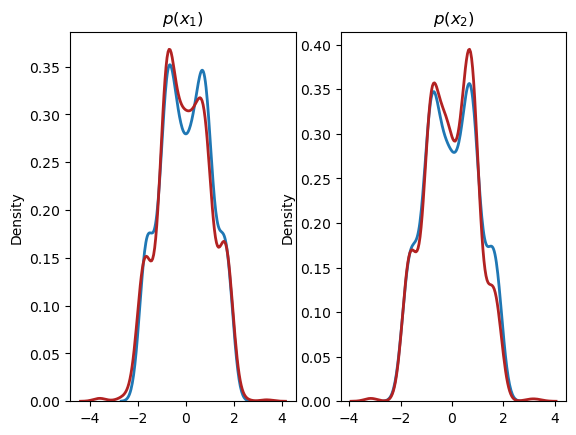

In [12]:
X_flow = flow_dist.sample(torch.Size([1000,])).detach().numpy()
plt.title(r'Joint Distribution')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.scatter(X[:,0], X[:,1], label='data', alpha=0.5)
plt.scatter(X_flow[:,0], X_flow[:,1], color='firebrick', label='flow', alpha=0.5)
plt.legend()
plt.show()

plt.subplot(1, 2, 1)
sns.distplot(X[:,0], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(X_flow[:,0], hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_1)$')
plt.subplot(1, 2, 2)
sns.distplot(X[:,1], hist=False, kde=True,
             bins=None,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='data')
sns.distplot(X_flow[:,1], hist=False, kde=True,
             bins=None, color='firebrick',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},
             label='flow')
plt.title(r'$p(x_2)$')
plt.show()